<a href="https://colab.research.google.com/github/Mubashar-Bashir/Langchain_EcoSystem/blob/main/Agentic001_Excise_MVR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_google_genai langchain_community

In [40]:
import os
from google.colab import userdata

os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Excise_Taxation_MVR"
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')

gemini_api_key = userdata.get('GEMINI_API_KEY')
tavily_api_key = userdata.get('TAVILY_API_KEY')

In [68]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    api_key=gemini_api_key
)

llm.invoke("greet me")

AIMessage(content='Hello there!\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-60bb06f7-eab8-410c-a7e1-f1948c220ec6-0', usage_metadata={'input_tokens': 3, 'output_tokens': 4, 'total_tokens': 7, 'input_token_details': {'cache_read': 0}})

In [69]:
# Part 1: Build a Basic Chatbot
# We'll first create a simple chatbot using LangGraph. This chatbot will respond directly to user messages. Though simple, it will illustrate the core concepts of building with LangGraph. By the end of this section, you will have a built rudimentary chatbot.

# Start by creating a StateGraph. A StateGraph object defines the structure of our chatbot as a "state machine". We'll add nodes to represent the llm and functions our chatbot can call and edges to specify how the bot should transition between these functions.

from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


# class State(TypedDict):
#     # Messages have the type "list". The `add_messages` function
#     # in the annotation defines how this state key should be updated
#     # (in this case, it appends messages to the list, rather than overwriting them)
#     # messages: Annotated[list, add_messages]
#   pass

# graph_builder = StateGraph(State)

In [70]:
from pydantic import BaseModel
class User_Profile():
    name: str|None
    fname:str|None
    age: int|None
    email: str|None
    cell_1: str|None
    cell_1: str|None

In [71]:
structured_user_profile = llm.with_structured_output(User_Profile)
structured_user_profile.invoke("Hi! My Name is Mubashar and age is 37")

ValueError: Function must have a docstring if description not provided.

In [73]:
from pydantic import BaseModel
# from langchain.llms import OpenAI

# Define the structured output schema
class User_Profile(BaseModel):
    name: str | None
    fname: str | None
    age: int | None
    email: str | None
    cell_1: str | None
    cell_2: str | None

# Initialize the LLM
llm = llm

# # Prompt to instruct the LLM to return structured data
# prompt = """
# Please provide your details in the following format:
# - Name if any first or starting name in the prompt is Name
# - Father's Name (fname) if any second Name str in the prompt is Father's Name
# - Age if any
# - Email if any str | None
# - Primary Cell Number (cell_1) if any
# - Secondary Cell Number (cell_2) if any
# """

response = llm.with_structured_output(User_Profile)

# Attempt to parse the response into the structured model
try:
    structured_user_profile = response.invoke(input=input("provide your profile"))
    print("Structured Output:", structured_user_profile)
except Exception as e:
    print("Error parsing structured output:", e)


provide your profilemy city is Guj and age is 36 name mubashar bashir cell 03344 and other cell 0344 and abc@gmail.com
Structured Output: name='mubashar bashir' fname='mubashar' age=36 email='abc@gmail.com' cell_1='03344' cell_2='0344'


In [5]:
from typing import Annotated, Literal

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, ToolMessage

# NOTE: you must use langchain-core >= 0.3 with Pydantic v2
from pydantic import BaseModel
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str


tool = TavilySearchResults(max_results=2)
tools = [tool]
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}


graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)


def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", END: END},
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["human"],
)

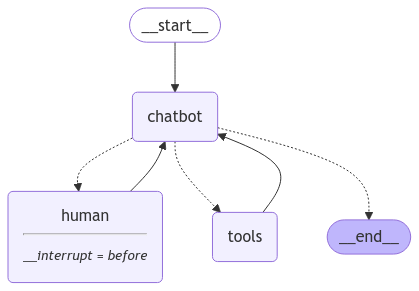

In [6]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [7]:
user_input = "I need some expert guidance for building this AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building this AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (45bcf4e7-695e-4bdf-9021-7511e612a77a)
 Call ID: 45bcf4e7-695e-4bdf-9021-7511e612a77a
  Args:
    request: I need some expert guidance for building this AI agent.


In [8]:
snapshot = graph.get_state(config)
snapshot.next

('human',)

In [9]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (45bcf4e7-695e-4bdf-9021-7511e612a77a)
 Call ID: 45bcf4e7-695e-4bdf-9021-7511e612a77a
  Args:
    request: I need some expert guidance for building this AI agent.
================================= Tool Message =================================

No response from human.
================================== Ai Message ==================================

I have requested assistance from an expert.  Unfortunately, I haven't received a response yet.


In [74]:
from typing import Annotated, Literal ,TypedDict
# from langchain_core import add_messages
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    # Conversational context
    messages: Annotated[list, add_messages]
    # Escalation flag
    # ask_human: bool # True or False
    # MVR-specific fields
    # intent: Literal[
    #     "TokenTaxCalculator",
    #     "VehicleVerification",
    #     "EAuctionNumbers",
    #     "VanityNumberPlates",
    #     "SmartCardTracking",
    #     "NumberPlateVerification",
    # ] | None
    # service_data: dict |None # Input data for the tool (e.g., reg_number, CC)
    # service_result: dict | None  # Result of the tool execution
    # error: str | None  # Error message if the tool fails


In [ ]:
# def deposit_money(name: str, bank_account_no: int) -> int:
#     """Deposit Money in Bank account.

#     Args:
#         name: first str
#         bank_account_no: second int
#     """
#     # BUSINESS LOGIC for Bank Deposit
#     # ......
#     return {"status": f"Deposit Successfule in {name} Account"}

In [167]:
#Tool Defination Tax calculator
from typing_extensions import  TypedDict
from typing import Optional , Dict
class TokenTaxCalculator(BaseModel):
    """Calculate token tax based on vehicle "reg_number" details."""
    reg_number: str  # Required field
    # cc: Optional[int]  # Optional field
    # year_of_reg: Optional[str]   # Optional with a default value of None

#token_tax_tool
def token_tax_tool(details: TokenTaxCalculator) -> dict:
    """
    Calculate token tax for a vehicle.

    Args:
        details (TokenTaxCalculator): Vehicle details with registration number,
        reg_number: first str
        # cc: optional second Optional[int]
        # year_of_reg: Optional[str] = None

    Returns:
        dict: Contains 'reg_number' and the calculated 'token_tax'.
    """
    tax = 10000 if details.reg_number == "ABC 123" else 15000
    return {"reg_number": details.reg_number, "token_tax": f"{tax} PKR"}


In [168]:
#vehicle Verification
class VehicleVerification(BaseModel): #BaseModel
    """Verify vehicle registration details."""
    reg_number: str # required Registration Number

def vehicle_verification_tool(details: VehicleVerification) -> dict:
    """
    Verify vehicle registration details. fetch reg number from prompt

    Args:
        details (VehicleVerification): Vehicle details with registration number,
        reg_number: first str
    Returns:
        dict: Contains 'status' and 'owner' details of the vehicle.
    """
    if details.reg_number.lower() in ["abc123", "abc 123", "abc123", "abc123"]:
        return {"status": "Active", "owner": "John Doe"}
    return {"status": "Not Found"}


In [169]:
class RequestAssistance(BaseModel): #BaseModel
    """Escalate the conversation to an expert."""
    request: str


In [170]:
tools = [
    token_tax_tool,vehicle_verification_tool
]
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


In [162]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, ToolMessage, tool


In [113]:
tools

[<function __main__.token_tax_tool(details: __main__.TokenTaxCalculator) -> dict>,
 <function __main__.vehicle_verification_tool(details: __main__.VehicleVerification) -> dict>]

In [171]:
def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    # ask_human = False
    # if (
    #     response.tool_calls
    #     and response.tool_calls[0]["name"] == RequestAssistance.__name__
    # ):
    #     ask_human = True
    return {
        "messages": [response],
        # "ask_human": ask_human,
    }


In [92]:
# def human_node(state: State):
#     new_messages = []
#     if not isinstance(state["messages"][-1], ToolMessage):
#         new_messages.append(
#             create_response("No response from human.", state["messages"][-1])
#         )
#     return {
#         "messages": new_messages,
#         "ask_human": False,
#     }


In [172]:
graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))
# graph_builder.add_node("human", human_node)

# Conditional routing
def select_next_node(state: State):
    # if state["ask_human"]:
    #     return "human"
    return tools_condition(state)

graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    { "tools": "tools", END: END}, #"human": "human",
)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", "chatbot")
# graph_builder.add_edge("human", "chatbot")


# Compile graph
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    # interrupt_before=["human"],
)


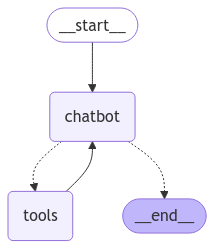

In [173]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [117]:
structured_response_for_token_tax = llm_with_tools.with_structured_output(TokenTaxCalculator)
structured_response_for_token_tax.invoke("I need tax calculation for my vehicle ABC?")

ValueError: no signature found for builtin type <class 'dict'>

In [128]:
# prompt: invoke above graph

user_input = "I need tax calculation for my vehicle?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
# for event in events:
#     if "messages" in event:
#         event["messages"][-1].pretty_print()
# snapshot = graph.get_state(config)
# snapshot.next
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

EmptyInputError: Received no input for __start__

In [ ]:
while True:  # Continuous interaction loop
    user_input = input("You: ")  # Take input from the user dynamically
    if user_input.lower() in ["exit", "quit"]:  # Option to exit the loop
        print("Exiting the chatbot. Goodbye!")
        break

    config = {"configurable": {"thread_id": "1"}}  # Configuration for the session
    # Stream the user's input through the graph
    events = graph.stream(
        {"messages": [("user", user_input)]}, config, stream_mode="values"
    )

    # Process and print responses
    for event in events:
        if "messages" in event:
            event["messages"][-1].pretty_print()

    # Retrieve the current state if needed
    snapshot = graph.get_state(config)
    print("Current State Snapshot:", snapshot.next)

    # # Stream more messages if needed
    # events = graph.stream(None, config, stream_mode="values")
    # for event in events:
    #     if "messages" in event:
    #         event["messages"][-1].pretty_print()


You: my name is Mubashar
================================ Human Message =================================

my name is Mubashar
================================== Ai Message ==================================

It's nice to meet you, Mubashar.  Is there anything else I can assist you with today?
Current State Snapshot: ()
You: check the vehicle ownership abc 123
================================ Human Message =================================

check the vehicle ownership abc 123
================================== Ai Message ==================================
Tool Calls:
  vehicle_verification_tool (34c4465f-d783-4da9-ae40-da75c5c883f5)
 Call ID: 34c4465f-d783-4da9-ae40-da75c5c883f5
  Args:
    details: {'reg_number': 'abc 123'}
================================= Tool Message =================================
Name: vehicle_verification_tool

{"status": "Active", "owner": "John Doe"}
================================== Ai Message ==================================

The vehicle with registrati